<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [51]:
!pip install datasets

Импорт необходимых библиотек

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [53]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [55]:
dataset = load_dataset('imdb')
sentences = []
word_threshold = 64

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x for x in sent_tokenize(sentence, language='english') if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [81]:
print(f"len(sentences): {len(sentences)}")
[sentence for sentence in sentences if len(sentence.split()) > 10][:10]

len(sentences): 79637


['If only to avoid making this type of film in the future.',
 'Lena Nyman has to be most annoying actress in the world.',
 '...I was just an early teen when this smoked fish hit the U.S.',
 'Some scenes are out of focus or taken from the wrong angle.',
 'This is said to be a personal film for Peter Bogdonavitch.',
 'They were not given any characters or good lines to work with.',
 'Peter B fans should stick to Last Picture Show and Target.',
 'The actors fall in love at first sight, words are unnecessary.',
 'Today I found "They All Laughed" on VHS on sale in a rental.',
 'The coincidences, in a huge city like New York, are ridiculous.']

Посчитаем для каждого слова его встречаемость.

In [57]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/79637 [00:00<?, ?it/s]

In [58]:
print(f"len(words): {len(words)}")
words.most_common()[:100]

len(words): 33279


[('.', 61825),
 ('the', 19094),
 (',', 18413),
 ('is', 14888),
 ('a', 14129),
 ('I', 13865),
 ('!', 11672),
 ('it', 10283),
 ('of', 9714),
 ('to', 9588),
 ('and', 8842),
 ('this', 8559),
 ('?', 7549),
 ('was', 7511),
 ("'s", 7142),
 ('movie', 7133),
 ('The', 6662),
 ('in', 6006),
 ("n't", 5281),
 ('that', 4967),
 ('It', 4910),
 ('>', 4514),
 ('/', 4512),
 ('<', 4502),
 ('br', 4494),
 ('film', 4220),
 ('This', 4164),
 ('for', 3907),
 ('not', 3805),
 ('you', 3683),
 ('``', 3258),
 ("''", 3129),
 ('are', 3022),
 ('have', 2793),
 ('on', 2747),
 ('be', 2736),
 ('one', 2696),
 ('all', 2546),
 ('as', 2541),
 ('with', 2516),
 ('do', 2388),
 (')', 2346),
 ('just', 2273),
 ('good', 2226),
 ('like', 2084),
 ('but', 2039),
 ('And', 1928),
 ('at', 1919),
 ('But', 1898),
 ('(', 1873),
 ('he', 1834),
 ('very', 1777),
 ('out', 1770),
 ('so', 1767),
 ('bad', 1723),
 ('me', 1703),
 ('really', 1700),
 ('did', 1638),
 ('they', 1618),
 ('about', 1608),
 ('...', 1587),
 ('an', 1575),
 ('has', 1549),
 ('no',

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [100]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>', ' '])
vocab_size = float('inf')
counter_threshold = 4

for i, (word, cnt) in enumerate(words.most_common()):
    if i < 25:
        print(f"'{word}'", cnt)
    if i >= vocab_size:
        break
#     if cnt < counter_threshold:
#         break
    vocab.add(word)
    
vocab_size = i + 1
print(vocab_size)
list(vocab)[:25]

'.' 61825
'the' 19094
',' 18413
'is' 14888
'a' 14129
'I' 13865
'!' 11672
'it' 10283
'of' 9714
'to' 9588
'and' 8842
'this' 8559
'?' 7549
'was' 7511
''s' 7142
'movie' 7133
'The' 6662
'in' 6006
'n't' 5281
'that' 4967
'It' 4910
'>' 4514
'/' 4512
'<' 4502
'br' 4494
33279


['Mel',
 'darkest',
 'ape',
 'Remind',
 'lunatic',
 'palates',
 'virago',
 'action',
 'repeating',
 'family-home-evening',
 'skanky',
 'begin',
 'Lovers',
 'Hogbottom',
 'powder',
 'Ahah',
 'impulse',
 'non-evolving',
 'Lt.',
 'retailer',
 'sacrifices',
 'implores',
 'Clausen',
 'predominantly',
 'admits']

In [60]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 33283


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [61]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [62]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id] 
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [63]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [64]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [65]:
def evaluate(model, criterion) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    perplexity = sum(perplexity) / len(perplexity)
    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [66]:
def train_model(model, criterion, optimizer, num_epoch=10):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion))
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [67]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [68]:
def plot_stats(losses, perplexities):
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()

    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Perplexity')
    plt.xlabel("epoch")
    plt.show()

In [69]:
defaul_model = WordLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(defaul_model.parameters())

losses, perplexities = train_model(defaul_model, criterion, optimizer)

Training epoch 0::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/498 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/498 [00:00<?, ?it/s]

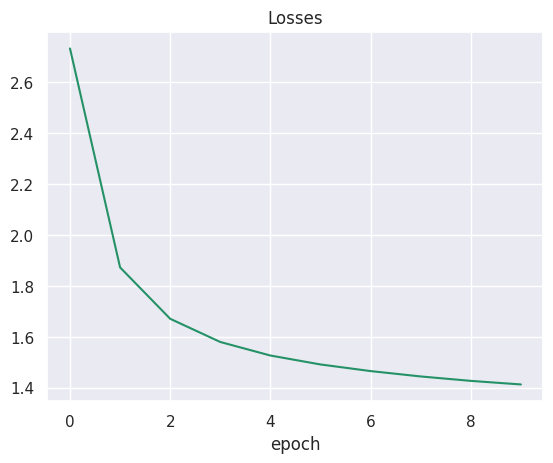

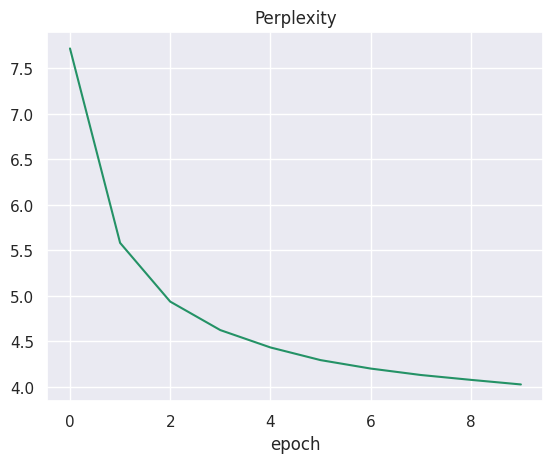

In [70]:
plot_stats(losses, perplexities)

In [95]:
def generate_sequence(model, starting_seq: [str], max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq]
    print(starting_seq)
    print(input_ids)
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [96]:
begin = 'The actors fall in love'
begin_words = begin.split(' ')
generate_sequence(defaul_model, starting_seq=begin_words)

['The', 'actors', 'fall', 'in', 'love']
[7421, 29152, 947, 13375, 16570, 32298]


'<bos> The actors fall in love n <unk> t h e <unk> m o v i e <unk> <unk> a s <unk> a <unk> <unk> i s a p p o i n t e <unk> <unk> t o <unk> t h e <unk> e n <unk> . <eos>'

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [73]:
class BiggerWordLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim * 2)
        self.projection = nn.Linear(hidden_dim * 2, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
bigger_model = BiggerWordLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(defaul_model.parameters())

losses, perplexities = train_model(bigger_model, criterion, optimizer, num_epoch=5)

def plot_stats(losses, perplexities):
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()

    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Perplexity')
    plt.xlabel("epoch")
    plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.